<a href="https://colab.research.google.com/github/neel26desai/data_cleaning_and_eda/blob/main/EDATimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview
Performing EDA, data cleaning, data prepration on a synthetic time series data generated by ChatGPT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/synthetic_time_series.csv')

In [ ]:
df.rename(columns = {"Unnamed: 0":"Date"},inplace=True)

In [ ]:
#converting Date column from object to datetime
df['Date']=pd.to_datetime(df['Date'])
#we'll set this date as the index
#lets make the date column as the index
df.set_index('Date',inplace=True)

In [ ]:
df.head()

,value
Date,
2020-01-01,0.039318
2020-01-02,-0.873642
2020-01-03,0.707097
2020-01-04,0.541720
2020-01-05,0.981200


## EDA

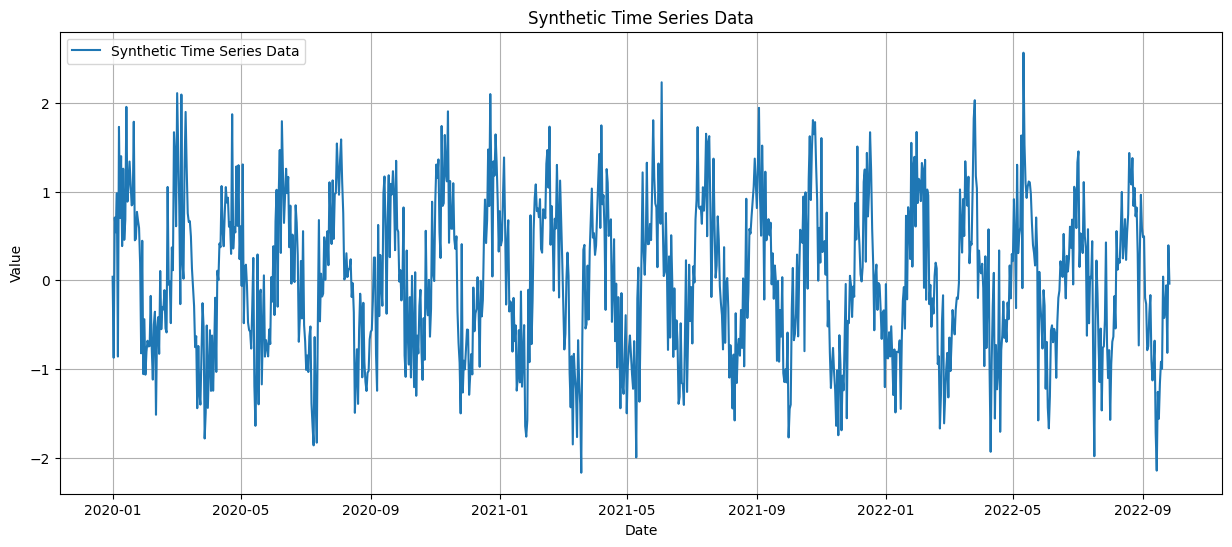

In [ ]:
# Visualization of the time series data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['value'], label='Synthetic Time Series Data')
plt.title('Synthetic Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Getting descriptive statistics
desc_stats = df.describe()

desc_stats

,value
count,1000.000000
mean,0.022069
std,0.868924
min,-2.169946
25%,-0.657529
50%,0.023653
75%,0.666872
max,2.565661


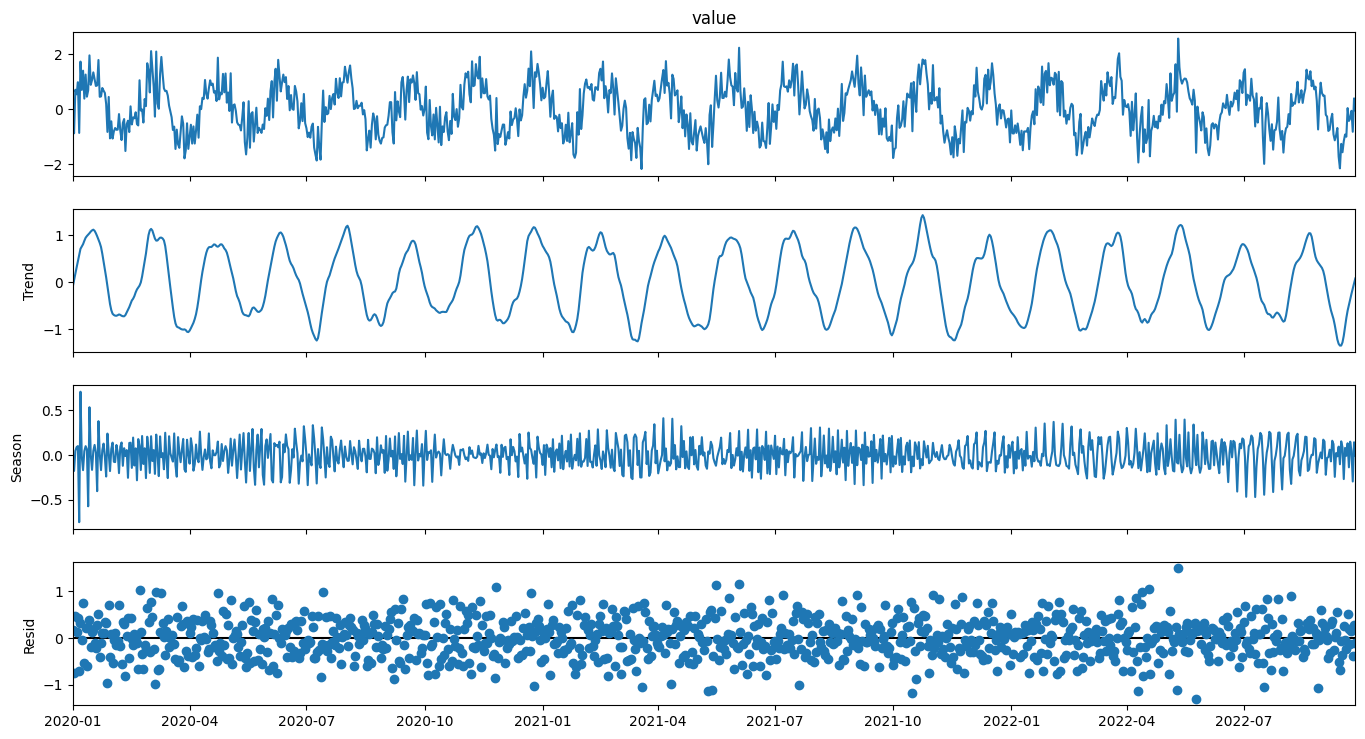

In [ ]:
from statsmodels.tsa.seasonal import STL

# Decomposing the time series using STL
stl = STL(df['value'], seasonal=13)
result = stl.fit()
# Plotting the decomposed time series without specifying the figsize directly
fig = result.plot()
fig.set_size_inches(15, 8)  # Adjusting the figure size
plt.show()

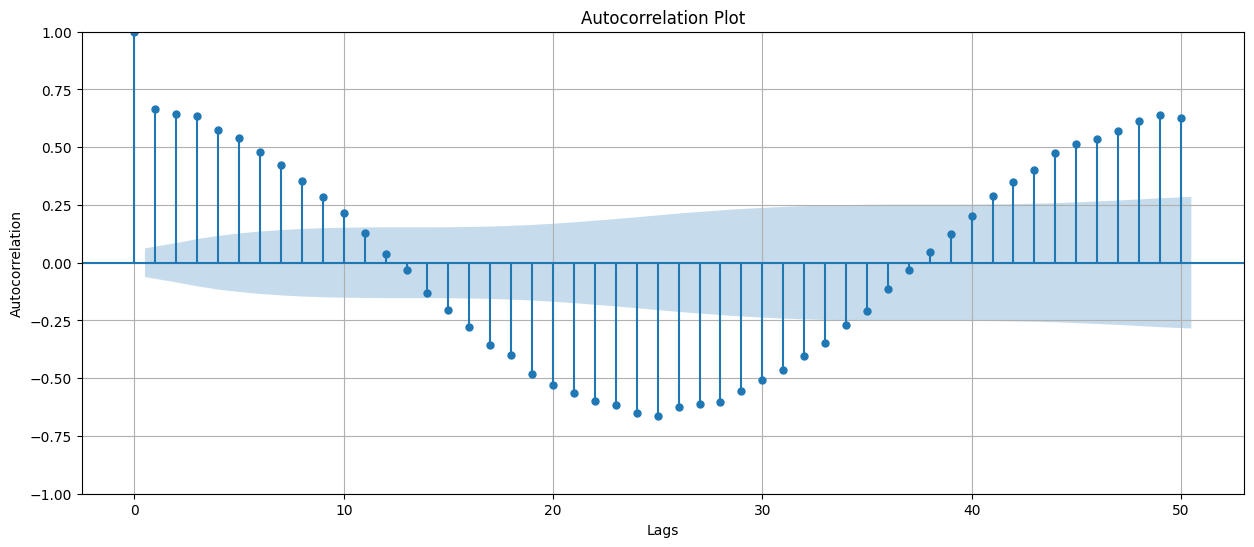

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plotting the autocorrelation plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df['value'], lags=50, ax=ax)
plt.title('Autocorrelation Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


## Data Cleaning

### Removing outliers

In [ ]:
# Detecting outliers using the IQR method

Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# Defining bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying the outliers
outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]

# Replacing outliers with NaN for now (we can decide later how to handle them)
df_cleaned = df.copy()
df_cleaned.loc[outliers.index, 'value'] = np.nan

# Displaying the number of detected outliers
num_outliers = len(outliers)

num_outliers


0

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
result = adfuller(df_cleaned['value'])

# Extracting the p-value from the test result
p_value = result[1]

p_value


5.389181468460677e-25

## Data Preparation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
df_cleaned['scaled_value'] = scaler.fit_transform(df_cleaned[['value']])

# Displaying the first few rows of the scaled data
df_cleaned.head()


,value,scaled_value
Date,,
2020-01-01,0.039318,0.019860
2020-01-02,-0.873642,-1.031344
2020-01-03,0.707097,0.788758
2020-01-04,0.541720,0.598338
2020-01-05,0.981200,1.104365


In [ ]:
# Creating lag features
for lag in range(1, 4):
    df_cleaned[f'lag_{lag}'] = df_cleaned['scaled_value'].shift(lag)

# Creating rolling statistics features
window = 7
df_cleaned['rolling_mean'] = df_cleaned['scaled_value'].rolling(window=window).mean()
df_cleaned['rolling_std'] = df_cleaned['scaled_value'].rolling(window=window).std()

# Dropping the initial rows which don't have lag and rolling statistics values
df_cleaned = df_cleaned.dropna()

df_cleaned.head()


,value,scaled_value,lag_1,lag_2,lag_3,rolling_mean,rolling_std
Date,,,,,,,
2020-01-07,1.729284,1.965728,-1.015444,1.104365,0.598338,0.347180,1.104182
2020-01-08,0.701279,0.782059,1.965728,-1.015444,1.104365,0.456066,1.104106
2020-01-09,1.398958,1.585383,0.782059,1.965728,-1.015444,0.829884,0.948603
2020-01-10,0.385356,0.418296,1.585383,0.782059,1.965728,0.776961,0.961526
2020-01-11,1.257831,1.422886,0.418296,1.585383,0.782059,0.894753,0.986187


In [ ]:
# Splitting the data into training and test sets
split_ratio = 0.8
split_idx = int(len(df_cleaned) * split_ratio)

train = df_cleaned.iloc[:split_idx]
test = df_cleaned.iloc[split_idx:]

# Defining the features and target
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']
target = 'scaled_value'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

X_train.shape, X_test.shape


((795, 5), (199, 5))

## Modelling

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Using auto_arima to find the best ARIMA parameters
# Training the ARIMA(1,1,1) model
arima_model = ARIMA(y_train, order=(1,1,1))
arima_fit = arima_model.fit()

# Predicting on the test set
arima_forecast = arima_fit.forecast(steps=len(y_test))

# Displaying the first few predictions
arima_forecast.head()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2022-03-12   -0.236143
2022-03-13   -0.213047
2022-03-14   -0.216054
2022-03-15   -0.215662
2022-03-16   -0.215713
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
import xgboost as xgb

In [ ]:
# Adjusting hyperparameters for faster training
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predicting on the test set
xgb_forecast = xgb_model.predict(X_test)

# Displaying the first few predictions
xgb_forecast[:5]


array([-0.17704794,  0.34923998,  0.09841517,  0.29100913,  0.52037024],
      dtype=float32)

In [ ]:
# Averaging the predictions from ARIMA and XGBoost models
ensemble_forecast = (arima_forecast.values + xgb_forecast) / 2

# Displaying the first few ensemble predictions
ensemble_forecast[:5]


array([-0.20659565,  0.06809638, -0.05881937,  0.03767332,  0.1523284 ])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluating the performance of each model and the ensemble method
arima_mae = mean_absolute_error(y_test, arima_forecast)
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
ensemble_mae = mean_absolute_error(y_test, ensemble_forecast)

arima_rmse = mean_squared_error(y_test, arima_forecast, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_forecast, squared=False)
ensemble_rmse = mean_squared_error(y_test, ensemble_forecast, squared=False)

evaluation = {
    "Model": ["ARIMA", "XGBoost", "Ensemble"],
    "MAE": [arima_mae, xgb_mae, ensemble_mae],
    "RMSE": [arima_rmse, xgb_rmse, ensemble_rmse]
}

evaluation_df = pd.DataFrame(evaluation)

evaluation_df


,Model,MAE,RMSE
0,ARIMA,0.814503,0.989687
1,XGBoost,0.520483,0.660965
2,Ensemble,0.579416,0.740769
